In [1]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/My Drive

Mounted at /content/drive
/content/drive/My Drive


In [2]:
%pip install pillow

In [3]:
# Import necessary libraries
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.applications import ResNet50, DenseNet121, MobileNetV3Small
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import Sequence
from sklearn.metrics import confusion_matrix, average_precision_score
import time
import matplotlib.pyplot as plt
import itertools
import os
from PIL import ImageFile
import warnings

# Ignore warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [4]:
# Define the custom image data generator
class CustomImageDataGenerator(Sequence):
    def __init__(self, directory, target_size=(224, 224), batch_size=10, classes=None, shuffle=True):
        self.directory = directory
        self.batch_size = batch_size
        self.target_size = target_size
        self.shuffle = shuffle
        self.classes = classes
        self.image_paths = []
        self.labels = []
        self._load_image_paths()
        self.on_epoch_end()

    def _load_image_paths(self):
        for class_index, class_name in enumerate(self.classes):
            class_dir = os.path.join(self.directory, class_name)
            for fname in os.listdir(class_dir):
                fpath = os.path.join(class_dir, fname)
                self.image_paths.append(fpath)
                self.labels.append(class_index)
        self.image_paths = np.array(self.image_paths)
        self.labels = np.array(self.labels)

    def __len__(self):
        return int(np.floor(len(self.image_paths) / self.batch_size))

    def __getitem__(self, index):
        batch_paths = self.image_paths[index * self.batch_size:(index + 1) * self.batch_size]
        batch_labels = self.labels[index * self.batch_size:(index + 1) * self.batch_size]
        images = []
        labels = []
        for img_path, label in zip(batch_paths, batch_labels):
            try:
                img = load_img(img_path)
                img = img.resize(self.target_size)
                img = img_to_array(img)
                images.append(img)
                labels.append(label)
            except Exception as e:
                print(f"Error loading image {img_path}: {e}")
                continue
        images = np.array(images, dtype="float32")
        labels = np.array(labels, dtype="int32")
        labels = tf.keras.utils.to_categorical(labels, num_classes=len(self.classes))
        return images, labels

    def on_epoch_end(self):
        if self.shuffle:
            indices = np.arange(len(self.image_paths))
            np.random.shuffle(indices)
            self.image_paths = self.image_paths[indices]
            self.labels = self.labels[indices]

In [5]:
# Set the directory paths
train_dir = '/content/drive/My Drive/AI-PROJECT/FlowersDataset/train'
validation_dir = '/content/drive/My Drive/AI-PROJECT/FlowersDataset/validation'
test_dir = '/content/drive/My Drive/AI-PROJECT/FlowersDataset/test'

# Define the classes
classes = ['dahlias', 'daisies', 'roses', 'lilies', 'sunflowers']

# Create data generators
train_batches = CustomImageDataGenerator(directory=train_dir, target_size=(224, 224), classes=classes, batch_size=10)
validation_batches = CustomImageDataGenerator(directory=validation_dir, target_size=(224, 224), classes=classes, batch_size=10)
test_batches = CustomImageDataGenerator(directory=test_dir, target_size=(224, 224), classes=classes, batch_size=10, shuffle=False)

In [6]:
# Check the structure of the data batches
print(f"Train batches: {len(train_batches.image_paths)} images, {len(classes)} classes")
print(f"Validation batches: {len(validation_batches.image_paths)} images, {len(classes)} classes")
print(f"Test batches: {len(test_batches.image_paths)} images, {len(classes)} classes")

# Assertions
assert len(train_batches.image_paths) == 7000  # 1400 images per class * 5 classes
assert len(validation_batches.image_paths) == 1500  # 300 images per class * 5 classes
assert len(test_batches.image_paths) == 1500  # 300 images per class * 5 classes
assert len(classes) == 5

Train batches: 7000 images, 5 classes
Validation batches: 1500 images, 5 classes
Test batches: 1500 images, 5 classes


In [7]:
# Function to build and compile model
def build_model(base_model):
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    predictions = Dense(len(classes), activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=predictions)
    for layer in base_model.layers:
        layer.trainable = False
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Function to calculate mAP
def calculate_map(y_true, y_pred):
    return average_precision_score(y_true, y_pred, average='macro')

# Function to plot confusion matrix
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion Matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    print(cm)
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j], horizontalalignment='center', color='white' if cm[i, j] > thresh else 'black')
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [8]:
# Define the CNN architectures
models = {
    "ResNet50": ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3)),
    "DenseNet121": DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3)),
    "MobileNetV3Small": MobileNetV3Small(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
}

# Enable mixed precision
tf.keras.mixed_precision.set_global_policy('mixed_float16')

# Training configurations
epochs = 50
results = {}

# Train and evaluate each model
for model_name, base_model in models.items():
    print(f"Training {model_name}...")
    model = build_model(base_model)

    start_time = time.time()
    history = model.fit(
        train_batches,
        epochs=epochs,
        validation_data=validation_batches
    )
    training_time = time.time() - start_time

    print(f"Evaluating {model_name}...")
    test_loss, test_accuracy = model.evaluate(test_batches)
    y_true = np.concatenate([test_batches[i][1] for i in range(len(test_batches))])
    y_pred = model.predict(test_batches)
    y_pred_classes = np.argmax(y_pred, axis=1)
    map_score = calculate_map(y_true, y_pred)

    results[model_name] = {
        "training_time": training_time,
        "test_accuracy": test_accuracy,
        "mAP": map_score,
        "history": history  # Store history for visualization
    }

    print(f"{model_name} - Training Time: {training_time:.2f} seconds, Test Accuracy: {test_accuracy:.4f}, mAP: {map_score:.4f}")

4334752/4334752 [==============================] - 0s 0us/step
Training ResNet50...
Epoch 1/50
700/700 [==============================] - 1565s 2s/step - loss: 0.5509 - accuracy: 0.8179 - val_loss: 0.4860 - val_accuracy: 0.8273
Epoch 2/50
700/700 [==============================] - 35s 49ms/step - loss: 0.2993 - accuracy: 0.8926 - val_loss: 0.4038 - val_accuracy: 0.8600
Epoch 3/50
700/700 [==============================] - 34s 49ms/step - loss: 0.2162 - accuracy: 0.9250 - val_loss: 0.3036 - val_accuracy: 0.8987
Epoch 4/50
700/700 [==============================] - 34s 49ms/step - loss: 0.1653 - accuracy: 0.9381 - val_loss: 0.3268 - val_accuracy: 0.8980
Epoch 5/50
700/700 [==============================] - 34s 49ms/step - loss: 0.1191 - accuracy: 0.9573 - val_loss: 0.4109 - val_accuracy: 0.8827
Epoch 6/50
700/700 [==============================] - 34s 49ms/step - loss: 0.0949 - accuracy: 0.9666 - val_loss: 0.3740 - val_accuracy: 0.9000
Epoch 7/50
700/700 [==============================] 

In [9]:
# Function to plot confusion matrix
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion Matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    print(cm)
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j], horizontalalignment='center', color='white' if cm[i, j] > thresh else 'black')
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

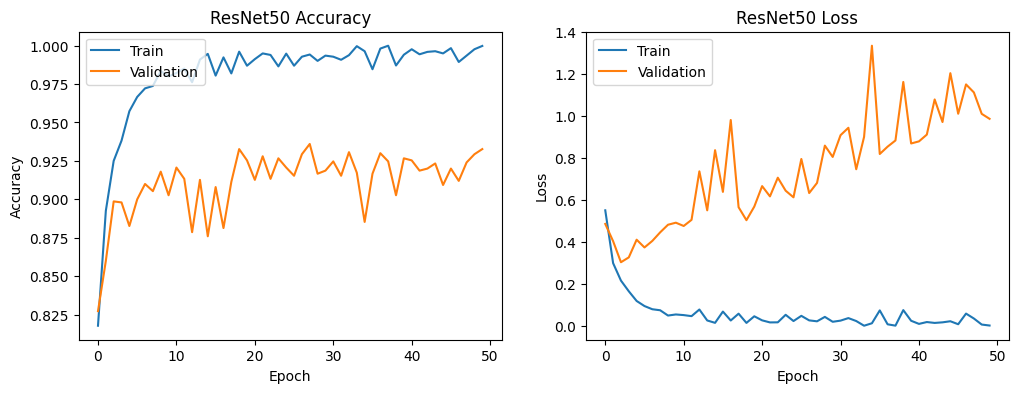

150/150 [==============================] - 5s 36ms/step
[[261   9   8  17   5]
 [  7 272   3   5  13]
 [  2   2 284  11   1]
 [  4   7   2 286   1]
 [  1   9   0   0 290]]


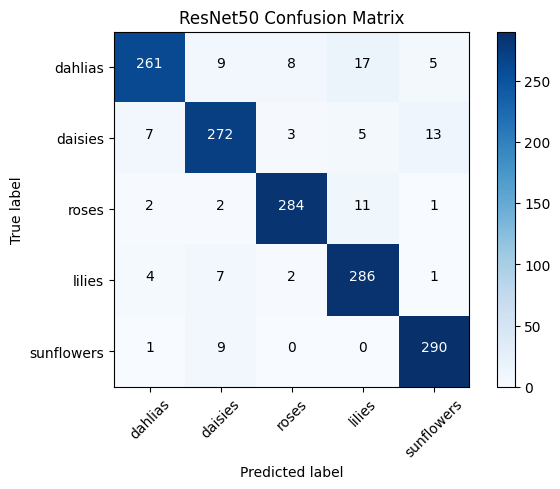

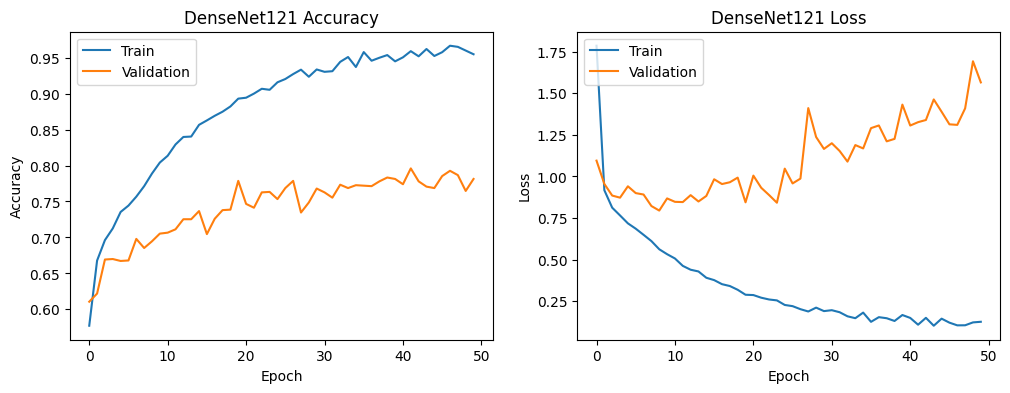

150/150 [==============================] - 5s 36ms/step
[[232  10  28  17  13]
 [ 35 217  14  18  16]
 [ 23   4 264   9   0]
 [ 32  14  31 211  12]
 [  4  12   6   2 276]]


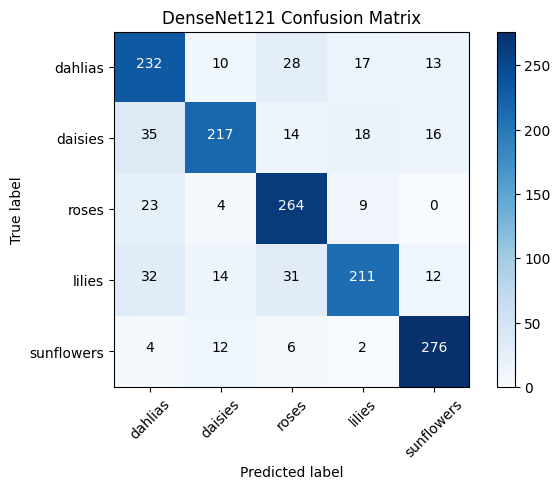

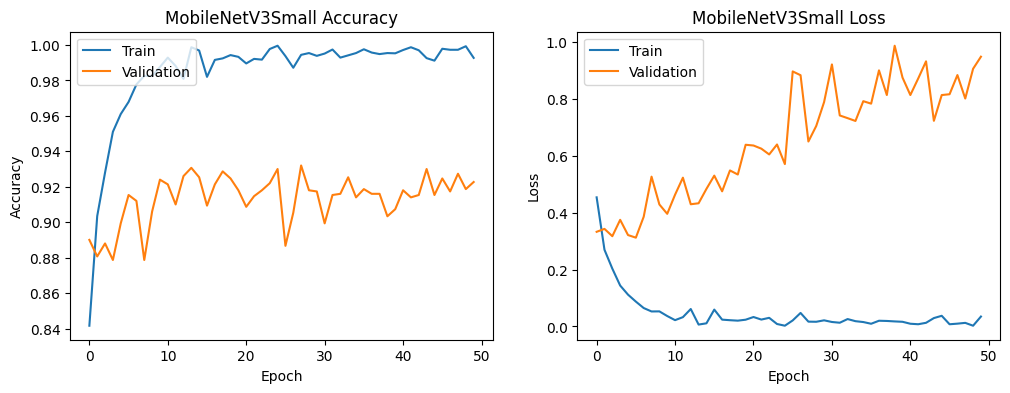

150/150 [==============================] - 5s 35ms/step
[[274  11   5   7   3]
 [ 15 265   1   6  13]
 [ 11   1 277   9   2]
 [  9  10   5 274   2]
 [  1   2   2   2 293]]
Results Summary:
ResNet50:
  Training Time: 3244.87 seconds
  Test Accuracy: 0.9287
  mAP: 0.9499
DenseNet121:
  Training Time: 1595.02 seconds
  Test Accuracy: 0.8000
  mAP: 0.8371
MobileNetV3Small:
  Training Time: 1519.97 seconds
  Test Accuracy: 0.9220
  mAP: 0.9361

Conclusion:
The best model for this classification task is ResNet50.
Considerations:
ResNet50:
  Parameters: Medium
  Training Time: 3244.87 seconds
  Test Accuracy: 0.9287
  mAP: 0.9499
DenseNet121:
  Parameters: Large
  Training Time: 1595.02 seconds
  Test Accuracy: 0.8000
  mAP: 0.8371
MobileNetV3Small:
  Parameters: Small
  Training Time: 1519.97 seconds
  Test Accuracy: 0.9220
  mAP: 0.9361


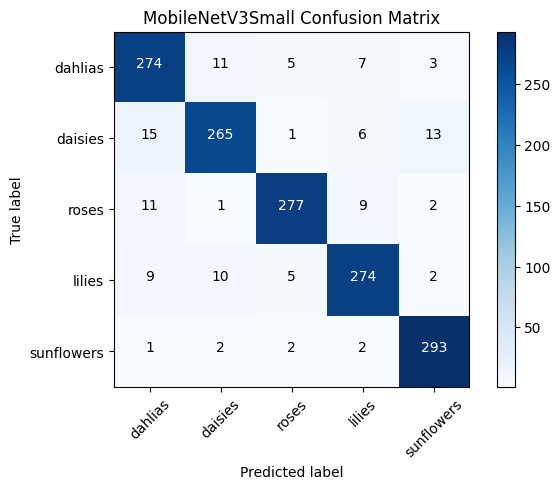

In [10]:
# Plot and visualize results
for model_name, metrics in results.items():
    history = metrics["history"]

    # Plot training & validation accuracy values
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title(f'{model_name} Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    # Plot training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title(f'{model_name} Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

    # Plot confusion matrix
    y_true = np.concatenate([test_batches[i][1] for i in range(len(test_batches))])
    y_pred = metrics["history"].model.predict(test_batches)
    y_pred_classes = np.argmax(y_pred, axis=1)
    cm = confusion_matrix(np.argmax(y_true, axis=1), y_pred_classes)
    plot_confusion_matrix(cm, classes=['dahlias', 'daisies', 'roses', 'lilies', 'sunflowers'], title=f'{model_name} Confusion Matrix')

# Print results summary
print("Results Summary:")
for model_name, metrics in results.items():
    print(f"{model_name}:")
    print(f"  Training Time: {metrics['training_time']:.2f} seconds")
    print(f"  Test Accuracy: {metrics['test_accuracy']:.4f}")
    print(f"  mAP: {metrics['mAP']:.4f}")

# Draw final conclusion
best_model = None
best_performance = 0

for model_name, metrics in results.items():
    performance = metrics['test_accuracy'] + metrics['mAP']  # Simple heuristic combining accuracy and mAP
    if performance > best_performance:
        best_performance = performance
        best_model = model_name

print(f"\nConclusion:")
print(f"The best model for this classification task is {best_model}.")
print(f"Considerations:")
for model_name, metrics in results.items():
    print(f"{model_name}:")
    print(f"  Parameters: {'Large' if 'Dense' in model_name else 'Medium' if 'ResNet' in model_name else 'Small'}")
    print(f"  Training Time: {metrics['training_time']:.2f} seconds")
    print(f"  Test Accuracy: {metrics['test_accuracy']:.4f}")
    print(f"  mAP: {metrics['mAP']:.4f}")